[Fold 1] Ep    1 | β 0.000 | Train 0.9171 | ValTot 0.8585 | ValRecon 0.8585
[Fold 1] Ep   20 | β 0.000 | Train 0.6896 | ValTot 0.7156 | ValRecon 0.7156
[Fold 1] Ep   40 | β 0.000 | Train 0.6638 | ValTot 0.7031 | ValRecon 0.7031
[Fold 1] Ep   60 | β 0.000 | Train 0.6456 | ValTot 0.7033 | ValRecon 0.7033
[Fold 1] Ep   80 | β 0.000 | Train 0.6367 | ValTot 0.7009 | ValRecon 0.7009
[Fold 1] Ep  100 | β 0.000 | Train 0.6089 | ValTot 0.6746 | ValRecon 0.6746
[Fold 1] Ep  120 | β 0.000 | Train 0.5885 | ValTot 0.6598 | ValRecon 0.6598
[Fold 1] Ep  140 | β 0.000 | Train 0.5790 | ValTot 0.6606 | ValRecon 0.6606
[Fold 1] Ep  160 | β 0.000 | Train 0.5682 | ValTot 0.6604 | ValRecon 0.6604
[Fold 1] Ep  180 | β 0.000 | Train 0.5620 | ValTot 0.6606 | ValRecon 0.6606
[Fold 1] Ep  200 | β 0.000 | Train 0.5588 | ValTot 0.6618 | ValRecon 0.6618
[Fold 1] Ep  220 | β 0.000 | Train 0.5569 | ValTot 0.6617 | ValRecon 0.6617
[Fold 1] Ep  240 | β 0.000 | Train 0.5560 | ValTot 0.6624 | ValRecon 0.6624
[Fold 1] Ep 

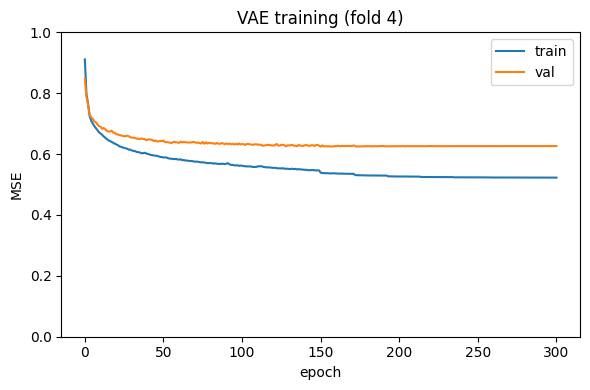

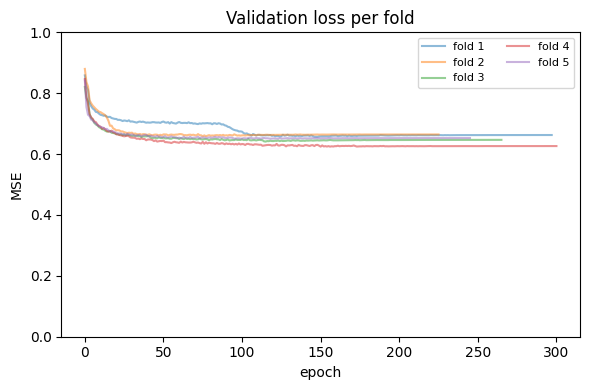

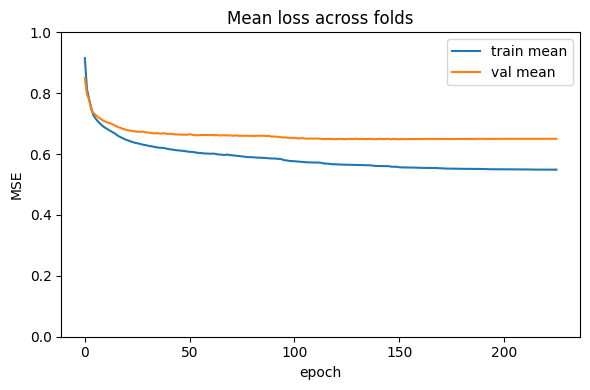

Best objective with SDR: 6.871371173176389


'\n# ============================================================\n# 3) Plots\n# ============================================================\n\n# 3.1 BO convergence\nZ_trials = BO_Z\nY_trials = BO_Y\nX2_trials = BO_X2\nbest_idx = int(np.argmin(Y_trials))\n\niters = np.arange(1, len(Y_trials) + 1)\nbest_so_far = np.minimum.accumulate(Y_trials)\n\nplt.figure(figsize=(6,4))\nplt.plot(iters, Y_trials, label="observed", linewidth=1.4)\nplt.plot(iters, best_so_far, label="best so far", linewidth=2)\nplt.xlabel("iteration")\nplt.ylabel("objective")\nplt.title("BO with SDR convergence")\nplt.legend()\nplt.tight_layout()\nplt.show()\n\n# 3.2 Latent space scatter (whitened → PCA if needed)\nlatent_dim = Z_trials.shape[1]\n\nif latent_dim > 2:\n    Z2 = PCA(n_components=2, random_state=SEED).fit_transform(Z_trials)\n    z0, z1 = Z2[:, 0], Z2[:, 1]\n    label0, label1 = "PCA(z0)", "PCA(z1)"\nelse:\n    z0, z1 = Z_trials[:, 0], Z_trials[:, 1]\n    label0, label1 = "z0 (whitened)", "z1 (whitened)"\

In [2]:
import numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from sklearn.decomposition import PCA
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

# ---------------------------- Antonio's Test Function Class ----------------------------

###############################################################################
#                           TestFunction Class                                #
###############################################################################

class TestFunction:
    """
    A class for evaluating various test functions for optimization algorithms.
    Supports Rosenbrock, Levy, Rastrigin, Ackley, and 1-norm.
    """

    def __init__(
        self,
        func_type,
        n_x,
        track_x=False,
        x_shift=None,
        bounds=None
    ):
        self.f_list = []
        self.x_list = []
        self.best_f = []

        self.func_type = func_type
        self.n_x       = n_x
        self.track_x   = track_x

        if x_shift is not None:
            self.x_shift = x_shift
        else:
            self.x_shift = np.zeros((n_x, 1))
        if bounds is not None:
            self.lb = bounds[:, 0]
            self.ub = bounds[:, 1]
        else:
            self.lb = np.zeros(n_x)
            self.ub = np.ones(n_x)
        self.dim      = n_x
        self.int_var  = np.array([], dtype=int)
        self.cont_var = np.arange(0, n_x)

    def eval(self, x):
        """
        Evaluate the chosen test function. Valid types are:
        - 'Rosenbrock_f'
        - 'Levy_f'
        - 'Rastrigin_f'
        - 'Ackley_f'
        - '1_norm'
        """
        x_arr = np.array(x).reshape((self.n_x, 1)) + self.x_shift

        if self.func_type == 'Rosenbrock_f':
            val = ((1.0 - x_arr)**2).sum() + 100.0 * ((x_arr[1:] - x_arr[:-1]**2)**2).sum()

        elif self.func_type == 'Levy_f':
            w = 1.0 + (x_arr - 1.0) / 4.0
            term1 = np.sin(np.pi * w[0])**2
            term2 = ((w[:-1] - 1.0)*2 * (1.0 + 10.0 * np.sin(np.pi * w[:-1] + 1.0)*2)).sum()
            term3 = (w[-1] - 1.0)*2 * (1.0 + np.sin(2.0 * np.pi * w[-1])*2)
            val = float(term1 + term2 + term3)

        elif self.func_type == 'Rastrigin_f':
            val = 10.0 * self.n_x + (x_arr**2 - 10.0 * np.cos(2.0 * np.pi * x_arr)).sum()
            val = float(val)

        elif self.func_type == 'Ackley_f':
            a, b, c = 20.0, 0.2, 2.0 * np.pi
            norm_sq = (x_arr**2).sum()
            term1 = -a * np.exp(-b * np.sqrt(norm_sq / self.n_x))
            term2 = -np.exp(np.cos(c * x_arr).sum() / self.n_x)
            val = float(term1 + term2 + a + np.e)

        elif self.func_type == '1_norm':
            val = float(np.abs(x_arr).sum())
        else:
            raise ValueError(f"Unsupported function type: {self.func_type}")

        self.f_list.append(val)
        if self.track_x:
            self.x_list.append(x_arr.copy())

        return val

    def best_f_list(self):
        """
        Compute best function values up to each evaluation.
        """
        accum_min = []
        current_best = float('inf')
        for val in self.f_list:
            if val < current_best:
                current_best = val
            accum_min.append(current_best)
        self.best_f = accum_min

    def pad_or_truncate(self, n_p):
        """
        Truncate or pad best_f and f_list to length n_p.
        """
        if not self.best_f:
            self.best_f_list()

        best_f_subset = self.best_f[:n_p]
        f_list_subset = self.f_list[:n_p]

        if best_f_subset:
            b_last = best_f_subset[-1]
            self.best_f_c = best_f_subset + [b_last] * (n_p - len(best_f_subset))
        else:
            self.best_f_c = [float('inf')] * n_p

        if f_list_subset:
            l_last = f_list_subset[-1]
            self.f_list_c = f_list_subset + [l_last] * (n_p - len(f_list_subset))
        else:
            self.f_list_c = [float('inf')] * n_p

# ---------------------------- 0) Repro + device ----------------------------
SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Choose function + domain via TestFunction
dim      = 20
func_name = "Ackley_f"   # or 'Rosenbrock_f', etc.
bounds   = np.array([[-5.0, 5.0]] * dim)  # your chosen box

t_func = TestFunction(
    func_type = func_name,
    n_x       = dim,
    track_x   = False,
    x_shift   = None,        # or a shift if you want
    bounds    = bounds,
)

# 2) Sample VAE training data in that box
N  = 10000
lb = t_func.lb              # shape (dim,)
ub = t_func.ub              # shape (dim,)

U = np.random.rand(N, dim)  # uniform in [0,1]
X = lb + U * (ub - lb)      # shape (N, dim)
X = X.astype(np.float32)

# ---------------------------- 2) VAE model (mean-decoder option) ----------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=5, mean_decoder=True):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(20,64), nn.LayerNorm(64), nn.SiLU(),
            nn.Linear(64,  32), nn.LayerNorm(32),  nn.SiLU(),
            nn.Linear(32,  16), nn.LayerNorm(16),  nn.SiLU(),
             nn.Linear(16,  8), nn.LayerNorm(8),  nn.SiLU(),
        )
        
        self.mu, self.logvar = nn.Linear(8,latent_dim), nn.Linear(8,latent_dim)
        
        self.dec = nn.Sequential(
            nn.Linear(latent_dim,8), nn.LayerNorm(8), nn.SiLU(),
            nn.Linear(8,16), nn.LayerNorm(16), nn.SiLU(),
            nn.Linear(16,32), nn.LayerNorm(32), nn.SiLU(),
            nn.Linear(32,64), nn.LayerNorm(64), nn.SiLU(),
            nn.Linear(64,20),
        )
       
        self.mean_decoder = mean_decoder

    def reparam(self, mu, lv):
        std = torch.exp(0.5*lv); 
        eps = torch.randn_like(std); 
        return mu + eps*std

    def forward(self, x):
        h = self.enc(x); 
        mu = self.mu(h); 
        lv = self.logvar(h)
        z = mu if self.mean_decoder else self.reparam(mu, lv)
        xhat = self.dec(z)
        return xhat, mu, lv, z

    @torch.no_grad()
    def encode_mu(self, x):
        h = self.enc(x); 
        return self.mu(h)

    @torch.no_grad()
    def decode(self, z):
        return self.dec(z)



# # ---------------------------- 3) K-Fold CV with β-freeze then linear ramp ----------------------------
# def kfold_vae_cv_torch(
#     X_full,
#     K=2,
#     latent_dim=5,
#     lr=1.75e-3,
#     batch=128,
#     max_epochs=500,
#     beta_start=0.0,
#     beta_inc=0.002,
#     beta_max=1.0,
#     patience=150,
#     seed=42,
#     log_every=20,
#     beta_freeze_epochs=100,   # β = 0 for these epochs, then ramp
# ):
#     kf = KFold(n_splits=K, shuffle=True, random_state=seed)
#     mse = nn.MSELoss(reduction='mean')

#     fold_recon = []
#     fold_histories = []
#     best_pack, best_val = None, np.inf

#     for fold, (tr_idx, va_idx) in enumerate(kf.split(X_full), 1):
#         Xtr_raw, Xva_raw = X_full[tr_idx], X_full[va_idx]
#         mu  = Xtr_raw.mean(axis=0, keepdims=True).astype(np.float32)
#         std = (Xtr_raw.std(axis=0, keepdims=True) + 1e-8).astype(np.float32)
#         Xtr = np.ascontiguousarray((Xtr_raw - mu) / std, dtype=np.float32)
#         Xva = np.ascontiguousarray((Xva_raw - mu) / std, dtype=np.float32)

#         train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(Xtr)),
#                                   batch_size=batch, shuffle=True)
#         val_loader   = DataLoader(TensorDataset(torch.from_numpy(Xva), torch.from_numpy(Xva)),
#                                   batch_size=256, shuffle=False)

#         model = VAE(latent_dim=latent_dim, mean_decoder=True).to(device)
#         opt = Adam(model.parameters(), lr=lr)
#         sched = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, min_lr=1e-6)

#         # initialise β and best_state
#         beta = beta_start
#         best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
#         best_val_fold, no_imp = np.inf, 0

#         train_hist, val_recon_hist, val_total_hist, beta_hist = [], [], [], []

#         for epoch in range(1, max_epochs + 1):
#             # β schedule with initial freeze, then linear ramp
#             if epoch <= beta_freeze_epochs:
#                 beta_eff = 0.0
#             else:
#                 beta = min(beta + beta_inc, beta_max)
#                 beta_eff = beta

#             # train
#             model.train()
#             tr_sum = 0.0
#             n_tr = 0
#             for xb, _ in train_loader:
#                 xb = xb.to(device)
#                 opt.zero_grad()
#                 xhat, mu_t, lv_t, _ = model(xb)
#                 recon = mse(xhat, xb)
#                 kl = -0.5 * torch.mean(torch.sum(1 + lv_t - mu_t.pow(2) - lv_t.exp(), dim=1))
#                 loss = recon + beta_eff * kl
#                 loss.backward()
#                 opt.step()
#                 tr_sum += loss.item() * xb.size(0)
#                 n_tr += xb.size(0)
#             tr_loss = tr_sum / n_tr

#             # validate
#             model.eval()
#             tot_sum = 0.0
#             rec_sum = 0.0
#             n_va = 0
#             with torch.no_grad():
#                 for xb, _ in val_loader:
#                     xb = xb.to(device)
#                     xhat, mu_t, lv_t, _ = model(xb)
#                     recon = mse(xhat, xb)
#                     kl = -0.5 * torch.mean(torch.sum(1 + lv_t - mu_t.pow(2) - lv_t.exp(), dim=1))
#                     tot = (recon + beta_eff * kl).item()
#                     tot_sum += tot * xb.size(0)
#                     rec_sum += recon.item() * xb.size(0)
#                     n_va += xb.size(0)

#             val_total = tot_sum / n_va
#             val_recon = rec_sum / n_va

#             # histories
#             train_hist.append(tr_loss)
#             val_recon_hist.append(val_recon)
#             val_total_hist.append(val_total)
#             beta_hist.append(beta_eff)

#             # scheduler and logs
#             sched.step(val_recon)
#             if epoch % log_every == 0 or epoch == 1:
#                 print(f"[Fold {fold}] Ep {epoch:4d} | β {beta_eff:0.3f} | "
#                       f"Train {tr_loss:.4f} | ValTot {val_total:.4f} | ValRecon {val_recon:.4f}")

#             # early stopping on val_recon
#             if val_recon < best_val_fold - 1e-12:
#                 best_val_fold = val_recon
#                 best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
#                 no_imp = 0
#             else:
#                 no_imp += 1
#                 if no_imp >= patience:
#                     print(f"[Fold {fold}] early stop at epoch {epoch}")
#                     break

#         # restore best and compute final fold MSE
#         model.load_state_dict(best_state)
#         model.to(device)
#         model.eval()
#         with torch.no_grad():
#             Xt = torch.from_numpy(Xva).to(device)
#             xhat = model(Xt)[0]
#             fold_mse = float(((xhat - Xt) ** 2).mean().cpu().item())

#         fold_recon.append(fold_mse)
#         print(f"[Fold {fold}] Val recon MSE: {fold_mse:.6f}")

#         # save fold history
#         fold_histories.append({
#             "train": train_hist,
#             "val_recon": val_recon_hist,
#             "val_total": val_total_hist,
#             "beta": beta_hist
#         })

#         # track best fold artefacts
#         if fold_mse < best_val:
#             best_val = fold_mse
#             best_pack = dict(model=model, mu=mu, std=std,
#                              latent_dim=latent_dim, fold_idx=fold - 1)

#     print(f"\nK-fold recon MSE mean={np.mean(fold_recon):.6f} std={np.std(fold_recon):.6f}")
#     return {"fold_recon": fold_recon, "best": best_pack, "histories": fold_histories}


# ---------------------------- 3) K-Fold CV ----------------------------
def kfold_vae_cv_torch(
    X_full,
    K=5,
    latent_dim=5,
    lr=1.75e-3,
    batch=128,
    max_epochs=500,
    beta_start=0.0,
    beta_inc=0.00,
    beta_max=0,
    patience=150,
    seed=42,
    log_every=20,
    #beta_freeze_epochs=100,
):
    kf = KFold(n_splits=K, shuffle=True, random_state=seed)
    mse = nn.MSELoss(reduction='mean')
    
    fold_recon = []
    fold_histories = [] 
    best_pack, best_val = None, np.inf

    for fold,(tr_idx,va_idx) in enumerate(kf.split(X_full),1):
        Xtr_raw, Xva_raw = X_full[tr_idx], X_full[va_idx]
        mu  = Xtr_raw.mean(axis=0, keepdims=True).astype(np.float32)
        std = (Xtr_raw.std(axis=0, keepdims=True)+1e-8).astype(np.float32)
    
        Xtr, Xva = (Xtr_raw-mu)/std, (Xva_raw-mu)/std

        Xtr = np.ascontiguousarray(Xtr, dtype=np.float32)      ## 
        Xva = np.ascontiguousarray(Xva, dtype=np.float32)      ##

        train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(Xtr)),
                                  batch_size=batch, shuffle=True)
        val_loader   = DataLoader(TensorDataset(torch.from_numpy(Xva), torch.from_numpy(Xva)),
                                  batch_size=256, shuffle=False)

        model = VAE(latent_dim=latent_dim, mean_decoder=True).to(device)
        opt = Adam(model.parameters(), lr=lr)
        sched = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, min_lr=1e-6)
        beta = beta_start
        
        best_val_fold, no_imp = np.inf, 0
        train_hist, val_recon_hist, val_total_hist, beta_hist = [], [], [], []

        for epoch in range(1, max_epochs+1):
            # ---- train ----
            model.train(); tr_sum=n_tr=0
            for xb,_ in train_loader:
                xb = xb.to(device); opt.zero_grad()
                xhat, mu_t, lv_t, _ = model(xb)
                recon = mse(xhat, xb)
                kl = -0.5*torch.mean(torch.sum(1 + lv_t - mu_t.pow(2) - lv_t.exp(), dim=1))
                loss = recon + beta*kl
                loss.backward(); opt.step()
                tr_sum += loss.item()*xb.size(0); n_tr += xb.size(0)
            tr_loss = tr_sum/n_tr

            # ---- val (report total & recon; select on recon) ----
            model.eval(); tot_sum=rec_sum=n_va=0
            with torch.no_grad():
                for xb,_ in val_loader:
                    xb = xb.to(device)
                    xhat, mu_t, lv_t, _ = model(xb)
                    recon = mse(xhat, xb)
                    kl = -0.5*torch.mean(torch.sum(1 + lv_t - mu_t.pow(2) - lv_t.exp(), dim=1))
                    tot = (recon + beta*kl).item()
                    tot_sum += tot*xb.size(0); rec_sum += recon.item()*xb.size(0); n_va += xb.size(0)
            val_total = tot_sum/n_va; val_recon = rec_sum/n_va

            train_hist.append(tr_loss)
            val_recon_hist.append(val_recon)
            val_total_hist.append(val_total)
            beta_hist.append(beta)

            sched.step(val_recon)
            if epoch % log_every==0 or epoch==1:
                print(f"[Fold {fold}] Ep {epoch:4d} | β {beta:0.3f} | Train {tr_loss:.4f} | "
                      f"ValTot {val_total:.4f} | ValRecon {val_recon:.4f}")

            # early stop on recon
            if val_recon < best_val_fold - 1e-12:
                best_val_fold = val_recon
                best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
                no_imp = 0
            else:
                no_imp += 1
                if no_imp >= patience:
                    print(f"[Fold {fold}] early stop at epoch {epoch}")
                    break

            beta = min(beta + beta_inc, beta_max)

        # ---- end fold: restore best and compute final val recon ----
        model.load_state_dict(best_state); model.to(device); model.eval()
        with torch.no_grad():
            Xt = torch.from_numpy(Xva).to(device)
            xhat = model(Xt)[0]
            fold_mse = float(((xhat - Xt)**2).mean().cpu().item())
        fold_recon.append(fold_mse)
        print(f"[Fold {fold}] Val recon MSE: {fold_mse:.6f}")


        fold_histories.append({
            "train": train_hist,
            "val_recon": val_recon_hist,
            "val_total": val_total_hist,
            "beta": beta_hist
        })

        if fold_mse < best_val:
            best_val = fold_mse
            best_pack = dict(model=model, mu=mu, std=std,
                     latent_dim=latent_dim, fold_idx=fold-1)

    print(f"\nK-fold recon MSE mean={np.mean(fold_recon):.6f} std={np.std(fold_recon):.6f}")
    return {"fold_recon": fold_recon, "best": best_pack, "histories": fold_histories}  # <-- add histories


# ---------------------------- 4) Run CV with the agreed settings ----------------------------
cv = kfold_vae_cv_torch(
    X_full=X,
    K=5,
    latent_dim=5,        # wider latent
    lr=1.75e-3,             # slightly higher LR
    batch=128,           # larger batch
    max_epochs=2000,
    beta_start=0.0,
    beta_inc=0.00,      # gentle warm-up
    beta_max=0,       # low cap
    patience=150,
    seed=SEED,
    log_every=20
   # beta_freeze_epochs=150,
)

best = cv["best"]
vae_model = best["model"]
mu_cv, std_cv = best["mu"], best["std"]

histories = cv["histories"]
best_idx = best.get("fold_idx", int(np.argmin(cv["fold_recon"])))

# best fold: train vs val
h = histories[best_idx]
plt.figure(figsize=(6,4))
plt.plot(h["train"], label="train")
plt.plot(h["val_recon"], label="val")
plt.ylim((0,1))
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title(f"VAE training (fold {best_idx+1})")
plt.legend(); plt.tight_layout(); plt.show()

# all folds overlay (validation)
plt.figure(figsize=(6,4))
for i,hi in enumerate(histories, 1):
    plt.plot(hi["val_recon"], alpha=0.5, label=f"fold {i}")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Validation loss per fold")
plt.legend(ncol=2, fontsize=8)
plt.ylim((0,1))
plt.tight_layout(); plt.show()


# optional: mean curve across folds (truncate to common length)
L = min(len(hi["val_recon"]) for hi in histories)
val_stack = np.stack([hi["val_recon"][:L] for hi in histories], axis=0)
train_stack = np.stack([hi["train"][:L] for hi in histories], axis=0)
plt.figure(figsize=(6,4))
plt.plot(train_stack.mean(0), label="train mean")
plt.plot(val_stack.mean(0), label="val mean")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Mean loss across folds")
plt.ylim((0,1))
plt.legend() 
plt.tight_layout()
plt.show()

'''#BO without SDR -- commented out for now

# ---------------------------- 5) BO on μ (best fold) ----------------------------
with torch.no_grad():
    Z = vae_model.encode_mu(torch.from_numpy(((X - mu_cv)/std_cv).astype(np.float32)).to(device)).cpu().numpy()

z_min, z_max = Z.min(axis=0), Z.max(axis=0)
pad = 0.05*(z_max - z_min + 1e-8)
bounds = [Real(float(lo - p), float(hi + p), name=f"z{i}") for i,(lo,hi,p) in enumerate(zip(z_min, z_max, pad))]

mu_np, std_np = mu_cv.astype(np.float32), std_cv.astype(np.float32)

@torch.no_grad()
def decode_np(z_vec_np):
    z_t = torch.from_numpy(z_vec_np.astype(np.float32)).to(device)
    return vae_model.decode(z_t).cpu().numpy()

def f20(x2, a=1.0, b=100.0):
    x, y = float(x2[0]), float(x2[1])
    return (a - x)*2 + b(y - x*2)*2

@use_named_args(bounds)
def objective(**zkw):
    z = np.array([zkw[f"z{i}"] for i in range(len(bounds))], dtype=np.float32)[None,:]
    xhat_n = decode_np(z)
    xhat   = xhat_n * std_np + mu_np
    return float(f20(xhat[0,:2]))


# --- BO history buffers ---
BO_Z, BO_Y, BO_X2 = [], [], []  # latent z tried, objective y, decoded (x0,x1)

@use_named_args(bounds)
def objective(**zkw):
    z = np.array([zkw[f"z{i}"] for i in range(len(bounds))], dtype=np.float32)[None,:]
    xhat_n = decode_np(z)
    xhat   = xhat_n * std_np + mu_np
    y = float(f20(xhat[0,:2]))

    # log
    BO_Z.append(z.squeeze().copy())
    BO_Y.append(y)
    BO_X2.append(xhat[0,:2].copy())
    return y


res = gp_minimize(objective, bounds, acq_func="EI", n_calls=60, n_initial_points=12, random_state=SEED)
print("Best objective:", res.fun)

# ---------------------------- 5) BO on μ (best fold) ----------------------------
with torch.no_grad():
    Z = vae_model.encode_mu(torch.from_numpy(((X - mu_cv)/std_cv).astype(np.float32)).to(device)).cpu().numpy()

z_min, z_max = Z.min(axis=0), Z.max(axis=0)
pad = 0.05*(z_max - z_min + 1e-8)
bounds = [Real(float(lo - p), float(hi + p), name=f"z{i}") for i,(lo,hi,p) in enumerate(zip(z_min, z_max, pad))]

mu_np, std_np = mu_cv.astype(np.float32), std_cv.astype(np.float32)

@torch.no_grad()
def decode_np(z_vec_np):
    z_t = torch.from_numpy(z_vec_np.astype(np.float32)).to(device)
    return vae_model.decode(z_t).cpu().numpy()

def f20(x2, a=1.0, b=100.0):
    x, y = float(x2[0]), float(x2[1])
    return (a - x)*2 + b(y - x*2)*2

@use_named_args(bounds)
def objective(**zkw):
    z = np.array([zkw[f"z{i}"] for i in range(len(bounds))], dtype=np.float32)[None,:]
    xhat_n = decode_np(z)
    xhat   = xhat_n * std_np + mu_np
    return float(f20(xhat[0,:2]))


# --- BO history buffers ---
BO_Z, BO_Y, BO_X2 = [], [], []  # latent z tried, objective y, decoded (x0,x1)

@use_named_args(bounds)
def objective(**zkw):
    z = np.array([zkw[f"z{i}"] for i in range(len(bounds))], dtype=np.float32)[None,:]
    xhat_n = decode_np(z)
    xhat   = xhat_n * std_np + mu_np
    y = float(f20(xhat[0,:2]))

    # log
    BO_Z.append(z.squeeze().copy())
    BO_Y.append(y)
    BO_X2.append(xhat[0,:2].copy())
    return y


res = gp_minimize(objective, bounds, acq_func="EI", n_calls=60, n_initial_points=12, random_state=SEED)
print("Best objective:", res.fun)'''

# 1) whiten Z for isotropy
from sklearn.preprocessing import StandardScaler
with torch.no_grad():
    Z_full = vae_model.encode_mu(torch.from_numpy(((X - mu_cv)/std_cv).astype(np.float32)).to(device)).cpu().numpy()
scZ = StandardScaler().fit(Z_full)
Z_wh = scZ.transform(Z_full)
z_min0, z_max0 = Z_wh.min(axis=0), Z_wh.max(axis=0)

def make_bounds(lo, hi):
    return [Real(float(l), float(h), name=f"z{i}") for i,(l,h) in enumerate(zip(lo, hi))]

orig_bounds = make_bounds(z_min0, z_max0)

mu_np = mu_cv.astype(np.float32)
std_np = std_cv.astype(np.float32)

@torch.no_grad()
def decode_np_from_whitened(z_wh_np):
    # invert whitening
    z = scZ.inverse_transform(z_wh_np)
    z_t = torch.from_numpy(z.astype(np.float32)).to(device)
    xhat_n = vae_model.decode(z_t).cpu().numpy()
    return xhat_n

BO_Z, BO_Y, BO_X2 = [], [], []

def make_objective():
    def obj_vec(z_vec):
        z_arr  = np.array(z_vec, dtype=np.float32)[None, :]
        xhat_n = decode_np_from_whitened(z_arr)
        xhat   = xhat_n * std_np + mu_np          # shape (1, 20)
        # call the true test function on the 20D vector
        y = t_func.eval(xhat[0])                  # Ackley_f in 20D
        BO_Z.append(z_arr.squeeze().copy())
        BO_Y.append(float(y))
        BO_X2.append(xhat[0, :2].copy())          # keep this if you still want (x0,x1) plots
        return float(y)
    return obj_vec

# 2) SDR hyperparameters
rounds = 5
calls_per_round = 12
init_points = 8
improve_tol = 1e-3
no_improve_patience = 1

# initial trust region is full box in whitened space
tr_lo, tr_hi = z_min0.copy(), z_max0.copy()
best_y = np.inf
no_imp = 0

rng = np.random.RandomState(SEED)

for r in range(1, rounds+1):
    dims = make_bounds(tr_lo, tr_hi)
    objective = make_objective()
    res = gp_minimize(
        func=objective,
        dimensions=dims,
        acq_func="EI",
        xi=0.01,
        n_calls=calls_per_round,
        n_initial_points=init_points if r == 1 else max(2, init_points//2),
        random_state=int(rng.randint(0, 10_000))
    )
    if res.fun < best_y - improve_tol:
        # success: move center to new best and gently expand
        best_y = res.fun
        z_best_wh = np.array(res.x, dtype=np.float32)
        width = (tr_hi - tr_lo)
        new_half = np.maximum(0.35*width, 0.10*(z_max0 - z_min0))  # keep some minimum span
        # small expansion
        new_half = np.minimum(new_half*1.2, 0.5*(z_max0 - z_min0))
        tr_lo = np.maximum(z_best_wh - new_half, z_min0)
        tr_hi = np.minimum(z_best_wh + new_half, z_max0)
        no_imp = 0
    else:
        # no improvement: shrink around current center
        no_imp += 1
        center = 0.5*(tr_lo + tr_hi)
        width = (tr_hi - tr_lo) * 0.5
        shrink = 0.5 if no_imp >= no_improve_patience else 0.7
        new_half = np.maximum(width*shrink, 0.05*(z_max0 - z_min0))
        tr_lo = np.maximum(center - new_half, z_min0)
        tr_hi = np.minimum(center + new_half, z_max0)

print("Best objective with SDR:", best_y)
BO_Z = np.asarray(BO_Z)
BO_Y = np.asarray(BO_Y)
BO_X2 = np.asarray(BO_X2)
'''
# ============================================================
# 3) Plots
# ============================================================

# 3.1 BO convergence
Z_trials = BO_Z
Y_trials = BO_Y
X2_trials = BO_X2
best_idx = int(np.argmin(Y_trials))

iters = np.arange(1, len(Y_trials) + 1)
best_so_far = np.minimum.accumulate(Y_trials)

plt.figure(figsize=(6,4))
plt.plot(iters, Y_trials, label="observed", linewidth=1.4)
plt.plot(iters, best_so_far, label="best so far", linewidth=2)
plt.xlabel("iteration")
plt.ylabel("objective")
plt.title("BO with SDR convergence")
plt.legend()
plt.tight_layout()
plt.show()

# 3.2 Latent space scatter (whitened → PCA if needed)
latent_dim = Z_trials.shape[1]

if latent_dim > 2:
    Z2 = PCA(n_components=2, random_state=SEED).fit_transform(Z_trials)
    z0, z1 = Z2[:, 0], Z2[:, 1]
    label0, label1 = "PCA(z0)", "PCA(z1)"
else:
    z0, z1 = Z_trials[:, 0], Z_trials[:, 1]
    label0, label1 = "z0 (whitened)", "z1 (whitened)"

plt.figure(figsize=(5,4))
sc = plt.scatter(z0, z1, c=Y_trials, s=35, cmap="viridis")
plt.colorbar(sc, label="objective")

n_init = init_points   # same as SDR init points
plt.scatter(
    z0[:n_init], z1[:n_init],
    facecolors="none", edgecolors="k", s=80, label="initial"
)
plt.scatter(
    z0[best_idx], z1[best_idx],
    color="red", s=140, label="best"
)

plt.xlabel(label0)
plt.ylabel(label1)
plt.title("Samples in latent space (whitened)")
plt.legend()
plt.tight_layout()
plt.show()

# 3.3 Decoded design space (x0,x1)
plt.figure(figsize=(5,4))
sc = plt.scatter(X2_trials[:, 0], X2_trials[:, 1], c=Y_trials, s=35, cmap="viridis")
plt.colorbar(sc, label="objective")

plt.scatter(
    X2_trials[:n_init, 0], X2_trials[:n_init, 1],
    facecolors="none", edgecolors="k", s=80, label="initial"
)
plt.scatter(
    X2_trials[best_idx, 0], X2_trials[best_idx, 1],
    color="red", s=140, label="best"
)

plt.xlabel("decoded x0")
plt.ylabel("decoded x1")
plt.title("Samples in decoded (x0,x1) space")
plt.legend()
plt.tight_layout()
plt.show()

# 3.5 SDR trust-region evolution (first two whitened dims)
if latent_dim >= 2:
    plt.figure(figsize=(6,6))
    num_boxes = TR_LO.shape[0]
    for k in range(num_boxes):
        lo = TR_LO[k]
        hi = TR_HI[k]
        x0, x1 = lo[0], hi[0]
        y0, y1 = lo[1], hi[1]
        alpha = 0.2 + 0.6 * (k / max(1, num_boxes - 1))
        plt.plot(
            [x0, x1, x1, x0, x0],
            [y0, y0, y1, y1, y0],
            color="C0",
            alpha=alpha,
        )

    plt.xlabel("whitened z0")
    plt.ylabel("whitened z1")
    plt.title("SDR trust region evolution (first two latent dims)")
    plt.tight_layout()
    plt.show()

    # width per dimension vs round
    widths = TR_HI - TR_LO
    rounds_idx = np.arange(widths.shape[0])
    plt.figure(figsize=(7,4))
    for d in range(latent_dim):
        plt.plot(rounds_idx, widths[:, d], label=f"dim {d}")
    plt.xlabel("SDR round")
    plt.ylabel("box width")
    plt.title("Trust region width per latent dimension")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3.6 Exploration intensity in latent space
steps = np.linalg.norm(Z_trials[1:] - Z_trials[:-1], axis=1)
plt.figure(figsize=(6,4))
plt.plot(steps, linewidth=1.4)
plt.xlabel("iteration")
plt.ylabel("latent step size")
plt.title("BO with SDR exploration intensity")
plt.tight_layout()
plt.show()'''